### 1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

### 2. При обучении моделей обязательно использовать кроссвалидацию

### 3. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)


### 4. Cделать выводы о том, какая модель справилась с задачей лучше других

### 5. (Опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

### Задача 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

Загрузка датасета

In [2]:
train_df = pd.read_csv('C:/Users/1/Downloads/Lection3-20220325T130313Z-001/Lection3/train_case2.csv', ';')
train_df.head(3)

C:\Users\1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3553: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
train_df.describe().round()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0
mean,49972.0,19469.0,1.0,164.0,74.0,129.0,97.0,1.0,1.0,0.0,0.0,1.0,0.0
std,28851.0,2467.0,0.0,8.0,14.0,154.0,188.0,1.0,1.0,0.0,0.0,0.0,1.0
min,0.0,10798.0,1.0,55.0,10.0,-150.0,-70.0,1.0,1.0,0.0,0.0,0.0,0.0
25%,25007.0,17664.0,1.0,159.0,65.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
50%,50002.0,19703.0,1.0,165.0,72.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
75%,74889.0,21327.0,2.0,170.0,82.0,140.0,90.0,2.0,1.0,0.0,0.0,1.0,1.0
max,99999.0,23713.0,2.0,250.0,200.0,16020.0,11000.0,3.0,3.0,1.0,1.0,1.0,1.0


In [4]:
TARGET_NAME = 'cardio'
NUM_FEATURE_NAMES = ['age', 'gender', 'height', 'weight', 'ap_hi',
                     'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns='cardio'), 
                                                    train_df['cardio'], random_state=0)

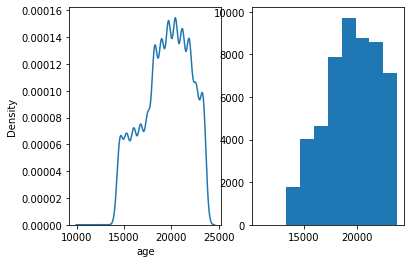

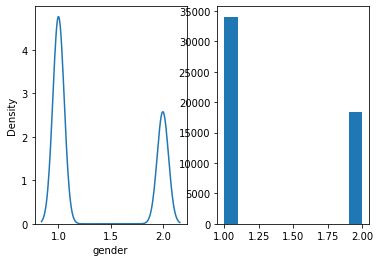

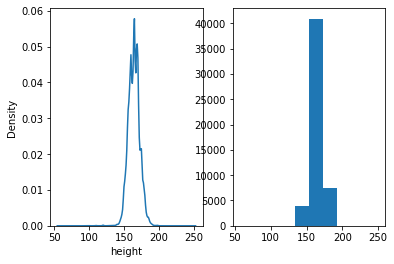

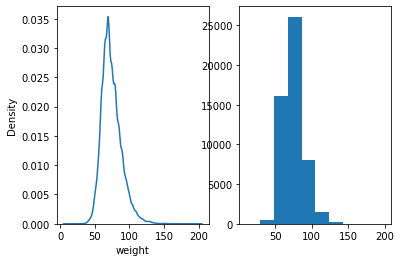

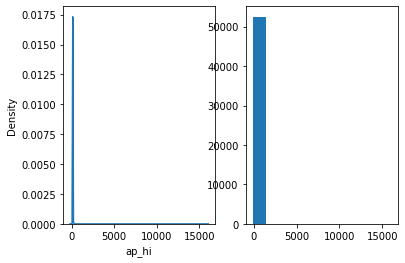

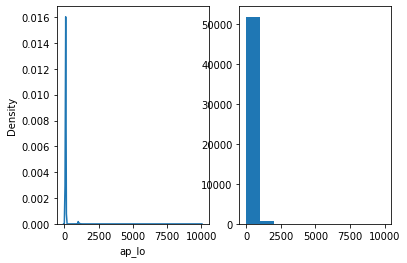

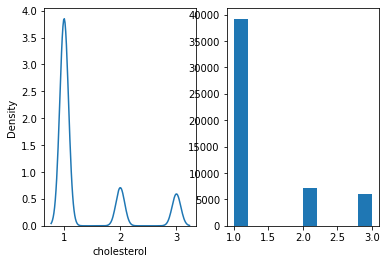

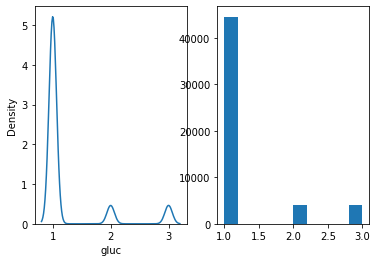

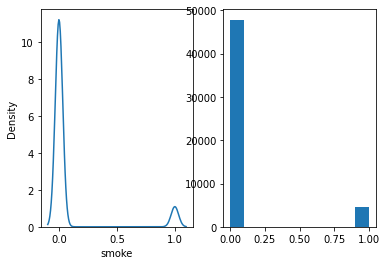

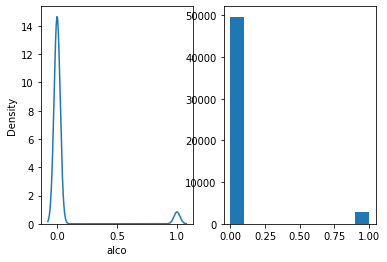

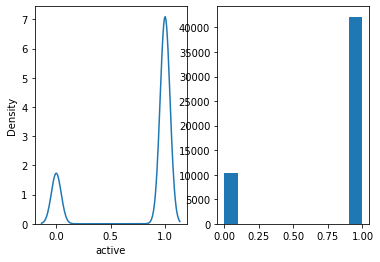

In [11]:
for name in NUM_FEATURE_NAMES:
    plt.subplot(1,2,1)
    sns.kdeplot(X_train[name])
    plt.subplot(1,2,2)
    plt.hist(X_train[name])
    plt.show()

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [8]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Обучение моделей

In [9]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier as rfc

In [11]:
def model_cv_score(model, rubl_test = 1400, rubl_early_treatment = 15000, rubl_late_treatment = 20000):

    print(f'\n{"*"*100}\nМодель: {model}\n')
  
    if model == 'LogisticRegression':
        classifier = Pipeline([
        ('features', feats),
        ('classifier', LogisticRegression(random_state=42)),
        ])

    elif model == 'XGBoost':
        classifier = Pipeline([
        ('features', feats),
        ('classifier', xgb.XGBClassifier(random_state=42, n_estimators=100)),
        ])  
    elif model == 'RandomForest':
        classifier = Pipeline([
        ('features', feats),
        ('classifier', rfc(random_state=42)),
       ])

  # запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'\nCV score is {cv_score}+-{cv_score_std}')

    # обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    print(y_score)

    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'\nBest Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

    roc_auc_score_train = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])
    roc_auc_score_test = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

    print(f"\nroc auc score train: {roc_auc_score_train}")
    print(f"roc auc score: {roc_auc_score_test}")

    cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])

    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    rubl_1 = (FN + TP) * rubl_late_treatment
    print('\nрасходы, если не делать тест и ждать симптомов:', rubl_1)  
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
    print('расходы, если делать тест всем и лечить группу большых:', rubl_test_all)
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
    print('расходы, если использовать МЛ:', rubl_ML)
    print('\nРасходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)

    return cv_score, precision[ix], recall[ix], fscore[ix], roc_auc_score_test, TN, FN, TP, FP, cnf_matrix, y_score

In [12]:
result = dict()
for model in ['LogisticRegression', 'XGBoost', 'RandomForest']:
    result[model] = model_cv_score(model)


****************************************************************************************************
Модель: LogisticRegression


CV score is 0.7864573689384385+-0.004422021036885763
[0.21919629 0.24759828 0.40484498 ... 0.16941878 0.70519218 0.75098778]

Best Threshold=0.38693708911473756, F-Score=0.730, Precision=0.647, Recall=0.838

roc auc score train: 0.7870081561637485
roc auc score: 0.7840347790421852

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если использовать МЛ: 152974200

Расходы "решение не делать тесты - расходы с МL:" 20625800
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1725800

****************************************************************************************************
Модель: XGBoost


CV score is 0.7971556462159913+-0.0025807632015828223
[0.1436425  0.19032502 0.35400474 ... 0.11356659 0